In [12]:
import pdb
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

from IPython.display import display
import matplotlib.pyplot as plt

# Data

In [2]:
def getData(filename, verbose=0):
    df             = pd.read_csv(filename)
    df.columns     = df.columns.str.strip()
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%d/%m/%y %H')
    df.set_index('DATETIME', inplace=True)
    
    
    if verbose:
        print (' -------------------------------------------------------------------------------------- ')
        print (' - Total Len : ', len(df))
        print (' - Label     : ', df['ATT_FLAG'].value_counts())
        print (' - Columns   : ', df.columns, ' || Total : ', len(df.columns))
        print (' - Dates     : ', df.index[0], ' -- ', df.index[-1])
        # print (df.head())
    return df
    

if __name__ == "__main__":
    df_train = getData('data/BATADAL_dataset03.csv', verbose=1)
    df_val   = getData('data/BATADAL_dataset04.csv', verbose=1)
    
    df_arma_predicted = pd.read_csv('results/02_ARMA_pred.csv')
    df_sax_predicted  = pd.read_csv('results/03_Discretization_vocab_abcd_PAA_10.csv')
    df_pca_predicted  = pd.read_csv('results/04_PCA.csv')
    
    print ('')
    print (' ------------------------------------------------ ')
    print (' - [RESULTS] : ARMA : cols : ', len(df_arma_predicted.columns))
    print (' - [RESULTS] : SAX : cols : ', len(df_sax_predicted.columns))
    print (' - [RESULTS] : PCA : cols : ', len(df_pca_predicted.columns))

 -------------------------------------------------------------------------------------- 
 - Total Len :  8761
 - Label     :  0    8761
Name: ATT_FLAG, dtype: int64
 - Columns   :  Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')  || Total :  44
 - Dates     :  2014-01-06 00:00:00  --  2015-01-06 00:00:00
 -------------------------------------------------------------------------------------- 
 - Total Len :  4177
 - Label     :  -999    3958
 1       219
Name: ATT_FLAG, dtype: int64
 - Columns   :  Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
   

# Task
 - % Q1 - Compare the performance of the PCA method with the ARMA and discrete models
 - % Q2 - Describe in a few lines which comparison method you chose for this data and why.
 - % Q3 - Do you recommend using PCA, ARMA or discrete models?
 - % Q3.1 - Keep in mind that in practice an analyst has to take action on every positive detected, but will not study every detected data point.

# Task - Aggregate results

In [8]:
def aggregate(df, column_name):
    df_anomaly_bool          = pd.DataFrame(df.nunique(axis = 1).eq(1))
    df_anomaly_bool.columns  = [column_name]
    
    # assuming that unique means it is uniquely -999
    df_res = df_anomaly_bool.applymap(lambda x: -999 if x == True else x)
    df_res = df_res.applymap(lambda x: 1 if x == False else x)
    return df_res
    
if __name__ == "__main__":
    df_arma_res = aggregate(df_arma_predicted, column_name='ARMA')
    df_sax_res  = aggregate(df_sax_predicted, column_name='SAX')
    df_pca_res  = df_pca_predicted

# Task - 1. Point wise metrics

,Method,TN,FP,FN,TP,Accuracy,Precsion,Recall,F-Score
0,ARMA,3858,189,100,30,93.081,13.699,23.077,17.192
1,SAX,2797,10,1161,209,71.966,95.434,15.255,26.306
2,PCA,3920,132,38,87,95.930,39.726,69.600,50.581


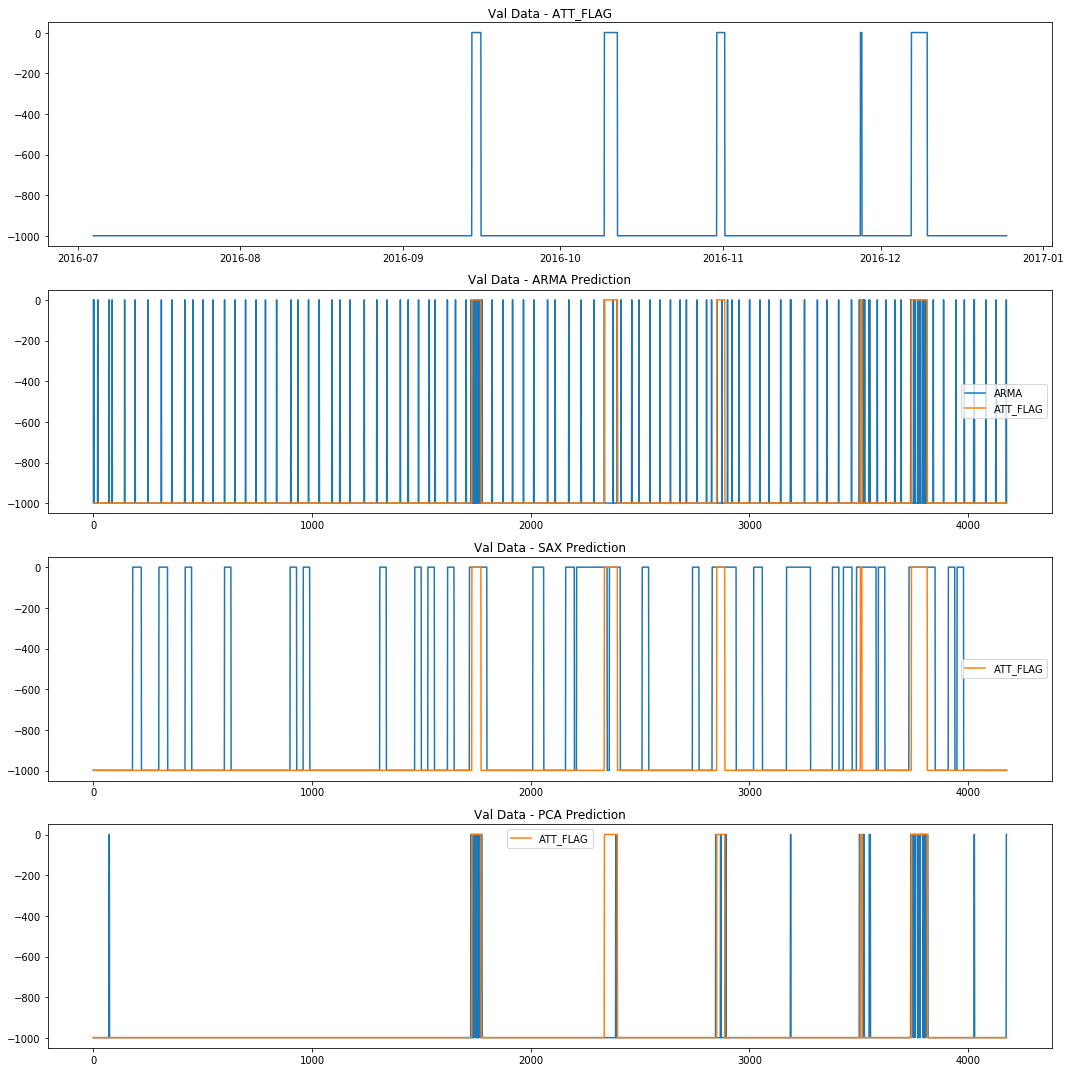

In [22]:
def getMetrics(df, df_val, method):
    tn, fp, fn, tp = confusion_matrix(df, df_val['ATT_FLAG']).ravel()
    accuracy       = 100.0 * (tp+tn)/(tp+tn+fp+fn)
    precision      = 100.0 * tp / (tp + fp)
    recall         = 100.0 * tp / (tp + fn)
    f_score        = 100.0 * 2 * tp /(2*tp + fp + fn)
    return [method, tn, fp, fn, tp, round(accuracy,3), round(precision,3), round(recall,3), round(f_score,3)]

if __name__ == "__main__":
    metrics_techniques = []
    metrics_arma = getMetrics(df_arma_res, df_val, 'ARMA')
    metrics_sax  = getMetrics(df_sax_res, df_val, 'SAX')
    metrics_pca  = getMetrics(df_pca_res, df_val, 'PCA')
    metrics_techniques.append(metrics_arma)
    metrics_techniques.append(metrics_sax)
    metrics_techniques.append(metrics_pca)
    
    df_metrics = pd.DataFrame(metrics_techniques, columns=['Method', 'TN', 'FP', 'FN', 'TP', 'Accuracy', 'Precsion', 'Recall', 'F-Score'])
    display(df_metrics)
    
    val_y_true = df_val['ATT_FLAG'].tolist()
    f,axarr = plt.subplots(4,1, figsize=(15,15))
    axarr[0].plot(df_val['ATT_FLAG'])
    axarr[0].set_title('Val Data - ATT_FLAG')
    
    axarr[1].plot(df_arma_res, label='ARMA')
    axarr[1].plot(val_y_true, label='ATT_FLAG')
    axarr[1].set_title('Val Data - ARMA Prediction')
    axarr[1].legend()
    
    axarr[2].plot(df_sax_res)
    axarr[2].plot(val_y_true, label='ATT_FLAG')
    axarr[2].set_title('Val Data - SAX Prediction')
    axarr[2].legend()
    
    axarr[3].plot(df_pca_res)
    axarr[3].plot(val_y_true, label='ATT_FLAG')
    axarr[3].set_title('Val Data - PCA Prediction')
    axarr[3].legend()
    f.tight_layout()

# Task - 2. Overlap metrics
 - Defining comparison metric. (Based on Time Series Discord)

In [25]:
def compute_S(anomalies, gamma, method):    
    
    # Step1 - Define attack_idxs
    attack_idxs = [
        [1731, 1772],
        [2337, 2396],
        [2851, 2887],
        [3508, 3514],
        [3741, 3813]
    ]
    
    # Step2 - Construct truth signal
    truth = np.zeros(len(anomalies))
    for attack_idx in attack_idxs:
        truth[attack_idx[0]:attack_idx[1]] = 1
    
    # Step3 - Compute S_ttd
    s = 0
    for attack_idx in attack_idxs:
        t     = attack_idx[1] - attack_idx[0] + 1
        ttd   = t
        flags = anomalies[attack_idx[0]:attack_idx[1]]
        for i, flag in enumerate(flags):
            if flag == 1:
                ttd = i
                break
        s += ttd / t
    s_ttd = 1 - s/len(attack_idxs)
    
    # Step4 - Compute s_cm
    TP   = len([x for i,x in enumerate(anomalies) if x == 1 and truth[i] == 1])
    TN   = len([x for i,x in enumerate(anomalies) if x == -999 and truth[i] == 0])
    TPR  = TP / sum(truth)
    TNR  = TN / (len(truth) - sum(truth))
    s_cm = 0.5 * (TPR + TNR)
    
    if (0):
        print("TPR: ", round(TPR,3))
        print("TNR: ", round(TNR,3))
    
    S = gamma * s_ttd + (1-gamma) * s_cm
    return (method, gamma, round(TPR,3), round(TNR,3), round(s_ttd,3), round(s_cm,3), round(S,3))

if __name__ == "__main__":
    gamma = 0.1
    
    metrics_overlap = []
    metrics_overlap_arma = compute_S(df_arma_res.values,gamma, 'ARMA')
    metrics_overlap_sax = compute_S(df_sax_res.values,gamma, 'SAX')
    metrics_overlap_pca = compute_S(df_pca_res.values,gamma, 'PCA')
    
    metrics_overlap.append(metrics_overlap_arma)
    metrics_overlap.append(metrics_overlap_sax)
    metrics_overlap.append(metrics_overlap_pca)
    
    df_metrics_overlap = pd.DataFrame(metrics_overlap, columns=['Method', 'Gamma', 'TPR', 'TNR', 'S_TTD', 'S_CM', 'S'])
    display(df_metrics_overlap)    

,Method,Gamma,TPR,TNR,S_TTD,S_CM,S
0,ARMA,0.1,0.136,0.975,0.767,0.555,0.576
1,SAX,0.1,0.953,0.706,1.000,0.830,0.847
2,PCA,0.1,0.402,0.990,0.535,0.696,0.680
